<a href="https://colab.research.google.com/github/KAVYANSHTYAGI/Ransomware-Analysis-using-Machine-Learning-and-Deep-Learning/blob/main/DL_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau , LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score,classification_report
from tensorflow.keras.preprocessing.image import load_img,img_to_array

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load your dataset
data_path = '/content/drive/MyDrive/ransomware_analysis_files/gan_for_synthetic/balanced_oversampled_very_noisy_extended_5k.csv'
dataset = pd.read_csv(data_path)

# Check and remove NaN values in the target variable 'Tag_y'
if dataset['Tag_y'].isnull().any():
    print("NaN values found in target variable 'Tag_y', removing rows...")
    dataset = dataset.dropna(subset=['Tag_y'])

X = dataset.drop(['Tag_y', 'Tag_x','filename', 'cryptographic_usage_encryption_algorithms','complexity_metrics_function_count', 'data_flow_collections_usage', 'hardcoded_urls', 'obfuscation_techniques_variable_name_length', 'unique_suspicious_strings'], axis=1)
y = dataset['Tag_y']


method 1

In [ ]:
# Normalize features to [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert labels to categorical
y_categorical = to_categorical(y)

# Reshape data into images
num_features = X_scaled.shape[1]
next_square = int(np.ceil(np.sqrt(num_features)))  # Calculate the next perfect square
total_pixels = next_square**2
padding_required = total_pixels - num_features

# Pad the features to make the number a perfect square
X_padded = np.pad(X_scaled, ((0, 0), (0, padding_required)), 'constant')
X_images = X_padded.reshape(-1, next_square, next_square, 1)  # Reshape into (number of samples, height, width, channels)


method 2

In [12]:
import pandas as pd
import numpy as np
from PIL import Image

# Function to convert CSV to image array directly in memory
def csv_to_image_array(data, dtype=None, img_dim=(128,128), img_type='RGB'):
    images = []
    no_of_features = data.shape[1]
    sqrt_of_no_of_features = int(np.sqrt(no_of_features))
    if np.sqrt(no_of_features) > sqrt_of_no_of_features:
        sqrt_of_no_of_features += 1

    for index, row in data.iterrows():
        pixels = np.resize(row.values, (sqrt_of_no_of_features**2)).reshape(sqrt_of_no_of_features, sqrt_of_no_of_features)
        image = Image.fromarray(pixels.astype(np.uint8))
        if img_type != 'Gray':
            image = image.convert(img_type)
        image = image.resize(img_dim, Image.Resampling.NEAREST)
        images.append(np.array(image))
    return np.array(images)

# Load your dataset
data_path = '/content/drive/MyDrive/ransomware_analysis_files/gan_for_synthetic/balanced_oversampled_very_noisy_extended_5k.csv'
dataset = pd.read_csv(data_path)

# Check for NaN values in the target variable and remove them if found
if dataset['Tag_y'].isnull().any():
    print("NaN values found in target variable 'Tag_y', removing rows...")
    dataset = dataset.dropna(subset=['Tag_y'])

# Dropping unnecessary columns
features_to_drop = ['Tag_y', 'Tag_x', 'filename', 'cryptographic_usage_encryption_algorithms',
                    'complexity_metrics_function_count', 'data_flow_collections_usage', 'hardcoded_urls',
                    'obfuscation_techniques_variable_name_length', 'unique_suspicious_strings']
X_data = dataset.drop(columns=features_to_drop)
y_train = dataset['Tag_y'].values  # Assuming y_train corresponds to the rows in the CSV

# Convert the filtered CSV data into images
X_train = csv_to_image_array(X_data, dtype='uint8', img_dim=(128, 128), img_type='RGB')

# Optionally, verify the shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


<ipython-input-12-7e4a8d12f041>:15: RuntimeWarning: invalid value encountered in cast
  image = Image.fromarray(pixels.astype(np.uint8))


X_train shape: (12012, 128, 128, 3)
y_train shape: (12012,)


In [17]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Function to resize images to a new size using TensorFlow
def resize_images(images, new_size=(224, 224)):
    # Ensure images are a tensor before resizing
    images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
    return tf.image.resize(images_tensor, new_size)

# Resize X_train to (224, 224)
X_train_resized = resize_images(X_train)

# Convert y_train to categorical
y_train_categorical = to_categorical(y_train)

# Print shapes to verify everything is as expected
print("Resized X_train shape:", X_train_resized.shape)
print("Categorical y_train shape:", y_train_categorical.shape)


Resized X_train shape: (9609, 224, 224, 3)
Categorical y_train shape: (9609, 2)


In [13]:
X_train, X_t, y_train, y_t = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_t, y_t, test_size=0.3, random_state=42)

In [16]:
import tensorflow as tf

def preprocess_images(images):
    images_resized = tf.image.resize(images, [224, 224, 3])
    return images_resized

X_train_resized = preprocess_images(X_train)
X_val_resized = preprocess_images(X_val)
X_test_resized = preprocess_images(X_test)

ValueError: 'size' must be a 1-D Tensor of 2 elements: new_height, new_width

In [ ]:
# Data Augmentation configuration
datagen = ImageDataGenerator(
    rotation_range=70,        # Random rotation between -10 to +10 degrees
    width_shift_range=0.1,    # Horizontal shift
    height_shift_range=0.1,   # Vertical shift
    zoom_range=0.1,           # Random zoom
    horizontal_flip=True,     # Horizontal flip
    fill_mode='nearest'  ,
    featurewise_center=True,
    featurewise_std_normalization=True
)

train_generator = datagen.flow(X_train_resized, y_train, batch_size=64)

In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(next_square, next_square, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y_categorical.shape[1], activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model with data augmentation
model.fit(datagen.flow(X_train_resized, y_train, batch_size=64),
          epochs=30,
          validation_data=(X_val_resized, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_resized, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv2d_8" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 224, 224, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
  • training=True
  • mask=None

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras import models
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

num_classes = 2

# Using MobileNetV2 as the base model with pre-trained ImageNet weights
base_model = VGG19(include_top=False,
                         weights='imagenet',
                         input_shape=(224, 224, 3))

# Setting the base model as non-trainable
base_model.trainable = False

# Building the complete model
model = models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='sigmoid')
])

# Configuring the optimizer
optimizer = Adam(learning_rate=1e-4)

# Compiling the model with necessary parameters
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',  # This is important for classification
              metrics=['accuracy'])

# Setting up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# The model is now ready to be trained with model.fit(), ensuring to provide validation data and using the callbacks


In [ ]:
print("Shape of X_train:", X_train_resized.shape)
print("Shape of X_test:", X_test_resized.shape)

for X_batch, y_batch in train_generator:
    print(X_batch.shape, y_batch.shape)
    break  # Just run one iteration to check

for X_batch, y_batch in train_generator:
    print('Batch X size:', X_batch.shape, 'Batch y size:', y_batch.shape)
    if X_batch.shape[0] != y_batch.shape[0]:
        print('Mismatch found')
    break  # Stop after the first batch to check

print('Validation X size:', X_val_resized.shape, 'Validation y size:', y_val.shape)
print('test X size:', X_test_resized.shape, 'test y size:', y_test.shape)


Shape of X_train: (9609, 224, 224, 3)
Shape of X_test: (721, 224, 224, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1273: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


(64, 224, 224, 3) (64, 2)
Batch X size: (64, 224, 224, 3) Batch y size: (64, 2)
Validation X size: (1682, 224, 224, 3) Validation y size: (1682, 2)
test X size: (721, 224, 224, 3) test y size: (721, 2)


Epoch 1/90


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


151/151 ━━━━━━━━━━━━━━━━━━━━ 126s 753ms/step - accuracy: 0.5014 - loss: 0.7159 - val_accuracy: 0.3157 - val_loss: 0.6932 - learning_rate: 1.0000e-04
Epoch 2/90
151/151 ━━━━━━━━━━━━━━━━━━━━ 101s 639ms/step - accuracy: 0.4965 - loss: 0.6981 - val_accuracy: 0.5172 - val_loss: 0.6916 - learning_rate: 1.0000e-04
Epoch 3/90
151/151 ━━━━━━━━━━━━━━━━━━━━ 101s 638ms/step - accuracy: 0.5191 - loss: 0.6929 - val_accuracy: 0.5059 - val_loss: 0.6905 - learning_rate: 1.0000e-04
Epoch 4/90
151/151 ━━━━━━━━━━━━━━━━━━━━ 101s 638ms/step - accuracy: 0.5283 - loss: 0.6916 - val_accuracy: 0.6076 - val_loss: 0.6882 - learning_rate: 1.0000e-04
Epoch 5/90
151/151 ━━━━━━━━━━━━━━━━━━━━ 101s 637ms/step - accuracy: 0.5158 - loss: 0.6927 - val_accuracy: 0.6147 - val_loss: 0.6868 - learning_rate: 1.0000e-04
Epoch 6/90
151/151 ━━━━━━━━━━━━━━━━━━━━ 101s 636ms/step - accuracy: 0.5434 - loss: 0.6858 - val_accuracy: 0.5196 - val_loss: 0.6784 - learning_rate: 1.0000e-04
Epoch 7/90
151/151 ━━━━━━━━━━━━━━━━━━━━ 100s 638ms/

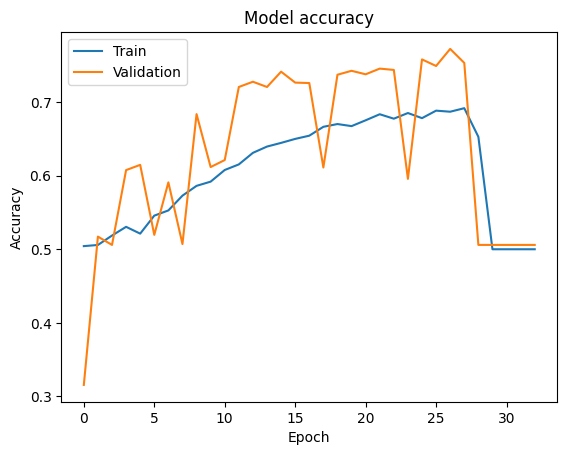

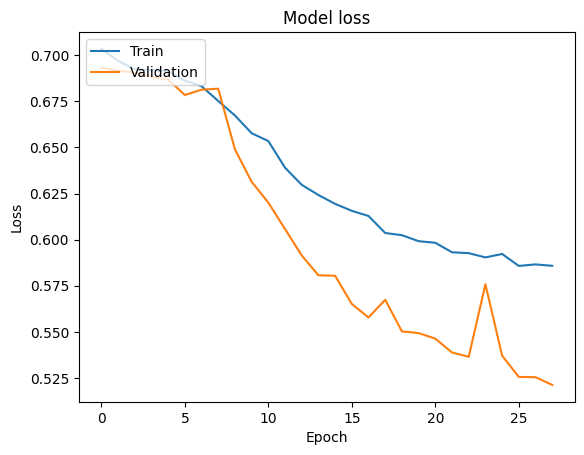

53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.7553 - loss: 0.5144
val Loss: 0.5212277173995972, val Accuracy: 0.7532699108123779
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 499ms/step - accuracy: 0.7548 - loss: 0.5230
test Loss: 0.5293155312538147, test Accuracy: 0.7503467202186584


In [ ]:
history = model.fit(
    train_generator,
    epochs=90,
    validation_data=(X_val_resized, y_val),
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    shuffle=True)

# Plotting training and validation loss and accuracy
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


loss, accuracy = model.evaluate(X_val_resized, y_val)
print(f'val Loss: {loss}, val Accuracy: {accuracy}')


loss, accuracy = model.evaluate(X_test_resized, y_test)
print(f'test Loss: {loss}, test Accuracy: {accuracy}')

